# XEUS-TiDB

xeus-tidb is a simple yet powerful Jupyter kernel for TiDB.

It allows the user to use the complete TiDB syntax as well as some extra operations such as opening or closing a database connection, or visualizing the data in different ways using Jupyter magics.

## Why we need it?
* TiDB 4.0: An Elastic, Real-Time HTAP Database
* Jupyter is the de facto IDE for scientific computing community
* SQL is the common language for all developers

## Use cases
* Development / Operational tools
* Interactive documentation 
* Data analysis

## Demo

Use Chinook dataset as an example, it's data model as follows: (credits [rpubs](https://rpubs.com/enext777/636199))

![chinook-models](chinook-models.jpg)

### SQL Clients

#### Connect to TiDB

Using `%LOAD` to connect to the instance

In [1]:
%LOAD tidb user=root host=127.0.0.1 port=4000 db=Chinook

Ok.

#### SQL commands

Then we can use any SQL commands supportted by TiDB

In [2]:
show databases;

Database
INFORMATION_SCHEMA
Chinook
METRICS_SCHEMA
PERFORMANCE_SCHEMA
mysql
test


In [3]:
select * from mysql.tidb order by VARIABLE_NAME;

VARIABLE_NAME,VARIABLE_VALUE,COMMENT
bootstrapped,True,Bootstrap flag. Do not delete.
new_collation_enabled,False,If the new collations are enabled. Do not edit it.
system_tz,Asia/Singapore,TiDB Global System Timezone.
tidb_server_version,59,Bootstrap version. Do not delete.
tikv_gc_auto_concurrency,true,"Let TiDB pick the concurrency automatically. If set false, tikv_gc_concurrency will be used"
tikv_gc_enable,true,Current GC enable status
tikv_gc_last_run_time,20210116-16:13:58 +0800,The time when last GC starts. (DO NOT EDIT)
tikv_gc_leader_desc,"host:C02CT123MD6R, pid:59690, start at 2021-01-16 15:33:58.077436 +0800 +08 m=+5.898535106",Host name and pid of current GC leader. (DO NOT EDIT)
tikv_gc_leader_lease,20210116-16:16:58 +0800,Current GC worker leader lease. (DO NOT EDIT)
tikv_gc_leader_uuid,5dc2875ca880001,Current GC worker leader UUID. (DO NOT EDIT)


A more complex SQL to get the top 10 sales artists

In [4]:
select at.Name as name, 
       sum(il.quantity) as total_quantity, 
       sum(il.quantity*il.unitPrice) as total_sales 
from track t
     inner join invoiceLine il on il.TrackId=t.TrackId
     inner join album a on a.AlbumId=t.AlbumId
     inner join artist at on at.ArtistId=a.ArtistId
group by 1
order by total_sales desc
limit 10;

name,total_quantity,total_sales
Iron Maiden,140,138.6
U2,107,105.93
Metallica,91,90.09
Led Zeppelin,87,86.13
Lost,41,81.59
The Office,25,49.75
Os Paralamas Do Sucesso,45,44.55
Deep Purple,44,43.56
Faith No More,42,41.58
Eric Clapton,40,39.6


As we can see, it's a fully functional SQL clients, and we can go beyond that!

### Data Visualization

Most data scientists use Jupyter and Python kernel to do data analyzing and visualizing. The main logic is to query data from databases and using matplotlib to do visualization, which full of glue code.

With xeus-tidb, we can easily achive this goal, and the code is more compact and maintainable. We use [vega-lite](https://vega.github.io/vega-lite/examples/) as our graphing tools. According to it's official website:
>  Vega-Lite is a high-level grammar of interactive graphics. It provides a concise, declarative JSON syntax to create an expressive range of visualizations for data analysis and presentation. 

And it had been bundled with JupyterLab by default. In xeus-tidb, we use the `%VEGA-LITE` magic code followed by the spec file which describe the graphing properties, and then the SQL command which get the data we want to plot. Quite simple, right? Let's go through some examples. 

#### line chart

A line chart gives us a clear visualization of where the price of a product has traveled over a given time period. In this example we can see the sales history by countries.

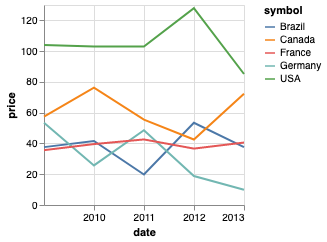

In [5]:
%VEGA-LITE specs/line_color.vl.json 
SELECT 
    EXTRACT(YEAR FROM invoiceDate) as date,
    BillingCountry as symbol,
    sum(total) as price
From Invoice
where BillingCountry in ("USA", "Canada", "Germany", "Brazil", "France")
group by date, symbol

#### bar chart

We use bar chart to visualizing a discrete, categorical data attribute. Let's see which genre of music is mostly sold in America.

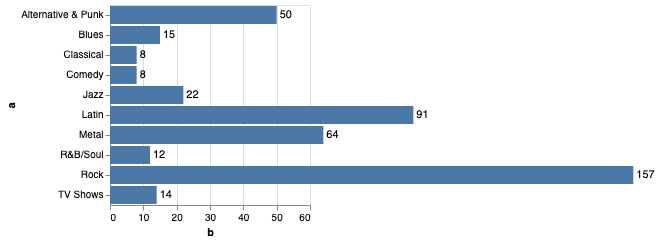

In [6]:
%VEGA-LITE specs/layer_bar_labels.vl.json 
SELECT 
    g.Name as a, 
    SUM(il.Quantity) as b, 
    ROUND((CAST(SUM(il.Quantity) as float) / (SELECT 
        SUM(Quantity) total
    FROM Chinook.InvoiceLine il
    INNER JOIN Chinook.Invoice i ON i.InvoiceId = il.InvoiceId
    WHERE i.BillingCountry = 'USA')) * 100, 2) percent_sold 
FROM Chinook.InvoiceLine il
INNER JOIN Chinook.Invoice i ON i.InvoiceId = il.InvoiceId 
INNER JOIN Chinook.Track t ON il.TrackId = t.TrackId 
INNER JOIN Chinook.Genre g ON t.GenreId = g.GenreId 
WHERE i.BillingCountry = 'USA' 
GROUP BY 1 
ORDER BY 2 DESC
LIMIT 10

#### pie chart
We can also use pie chart for this.

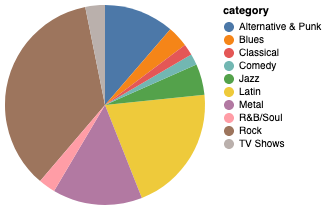

In [7]:
%VEGA-LITE specs/arc_pie.vl.json 
SELECT 
    g.Name as category, 
    SUM(il.Quantity) as b, 
    ROUND((CAST(SUM(il.Quantity) as float) / (SELECT 
        SUM(Quantity) total
    FROM Chinook.InvoiceLine il
    INNER JOIN Chinook.Invoice i ON i.InvoiceId = il.InvoiceId
    WHERE i.BillingCountry = 'USA')) * 100, 2) value 
FROM Chinook.InvoiceLine il
INNER JOIN Chinook.Invoice i ON i.InvoiceId = il.InvoiceId 
INNER JOIN Chinook.Track t ON il.TrackId = t.TrackId 
INNER JOIN Chinook.Genre g ON t.GenreId = g.GenreId 
WHERE i.BillingCountry = 'USA' 
GROUP BY 1 
ORDER BY 2 DESC
LIMIT 10



#### scatterplot

Please notice that above examples directly use the specs from vega-lite example gallery without any modification, you can just find the spec you want and use it in your code.

And as the specs are just plain json files, it's easy to adapt to our needs. Let's first use scatterplot as an example to show the relation between track numbers and sales

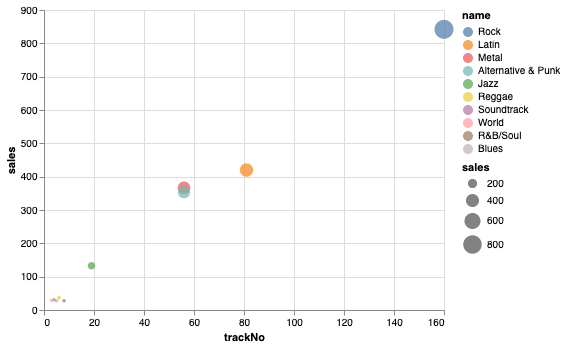

In [8]:
%VEGA-LITE colored_scatterplot.vl.json 
select g.name name, sum(i.total) sales, count(distinct t.trackId) trackNo 
from track t 
    inner join genre g on g.genreId=t.genreId 
    inner join invoiceLine il on il.trackId=t.trackId
    inner join invoice i on i.invoiceId=il.invoiceLineId
group by g.name
order by sales desc limit 10;

#### heatmap
Another example using heatmap to show which genre is most popular in each country.

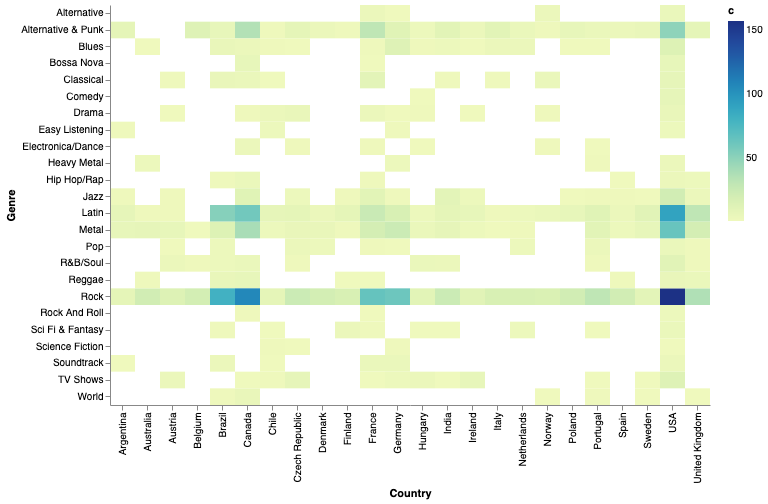

In [9]:
%VEGA-LITE rect_category_heatmap.vl.json 
select i.BillingCountry as Country, g.name as Genre, count(1) as c
from invoice i 
    inner join InvoiceLine il on i.InvoiceId=il.InvoiceId 
    inner join track t on t.TrackId=il.TrackId 
    inner join genre g on g.GenreId=t.GenreId
group by 1,2

With all of this, even a PM without any programming backgrounds can do data visualization by themselves, as long as they know SQL commands.

## The Implementation
https://github.com/wangfenjin/xeus-tidb
* Jupyter community (you can also use xeus-tidb in vscode)
* jupyter-xeus: a framework for developing Jupyter kernel
* soci-mysql: mysql client library
* vega / vega-lite: a high-level grammar of interactive graphics

## The Future
* Integrate into TiUP? So after `tiup playground`, we can setup a jupyter server and some default notebooks to let users learn and play with the data.
* Build a TiDB cluster operational runbook? So we can help DBA's better manage the TiDB cluster, and directly do it in Jupyter.
* Implement more magic commands such as integrate with machine learning algorithms? So we can further lower the bar of being a data scientist.